# Author text information clustering

##### The code below will allow to cluster based on the text information from the author's papers. The input is the csv file "papers.csv" but in json format, and also "paper_authors.csv" to get the author ID.

### 1. Import the libraries to be used

In [1]:
import pandas as pd
import nltk
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from scipy.spatial.distance import cdist, pdist
import matplotlib.pyplot as plt
from time import time
import json
from pprint import pprint
import csv
%matplotlib inline
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

### 2. Import data to create a structure "author_id" and "paper_text"

In [2]:
#dataframe of "paper_id and author_id"
from pathlib import Path
d = Path().resolve().parent.parent
d1 = str(d) + "/data/original/paper_authors.csv"
d2 = str(d) + "/data/original/papers.json"

df_1 = pd.read_csv(d1)
#df_1 = pd.read_csv('paper_authors.csv')
print("Dataframe 1 Paper-Author :",len(df_1))

#Read "papers" (dictionary)
with open('d2') as data_file:
#with open('papers.json') as data_file:
    dic2 = json.load(data_file)
#Dictionary to dataframe
df_2 = pd.DataFrame(dic2, columns = ['paper_text', 'paper_id', 'title'])
print("Dataframe 2 Papers :",len(df_2))

df = pd.merge(df_1, df_2, how='left', on='paper_id')
#merged.to_csv('merged.csv', index=False)
#construct data frame with format: "paper_text","author_id","title"
df = df[['paper_text', 'author_id', 'title']]
print("Dataframe final :",len(df))

Dataframe 1 Paper-Author : 18321
Dataframe 2 Papers : 6560
Dataframe final : 18321


#### Get authors list

In [3]:
#Get list of unique nodes

csv = pd.read_csv('paper_authors.csv')
paper_id = {}
for it in range(0,len(csv)):
    num = csv['paper_id'][it]
    if num in paper_id:
        paper_id[num].append(csv['author_id'][it])
    else:
        paper_id[num] = []
        paper_id[num].append(csv['author_id'][it])
final = []
for it in paper_id.items():
    if(len(it[1])>=2):
        au_paper = 0
        for au in range(0,len(it[1])-1):
            for au2 in range(au+1,len(it[1])):
                x = [it[1][au],it[1][au2]]
                final.append(x)

#Remove duplicates
newListaF = sorted(final)
listaFinal = [newListaF[i] for i in range(len(newListaF)) if i==0 or newListaF[i] != newListaF[i-1]]

flist=[]
for x in listaFinal:
    for y in range(2):
        if x[y] not in flist:
            flist.append(x[y])

print("Number of unique authors: ", len(flist))

Number of unique authors:  8457


#### Create a dictionary with key: author_id, value: list of author's papers

In [4]:
#Transform dataframe into dictionary, key: author_id, value: all papers
d = df.groupby('author_id')['paper_text'].apply(list).to_dict()
print("Dictionary final :",len(d))

Dictionary final : 8653


In [5]:
#Merge all the docs of an author together
for x in d:
    helper = " "
    for y in (range(len(d[x]))):
        helper += (d[x][y])
    d[x] = helper
    #print(len(test))

In [6]:
#Create list of pairs "Author_ID" and "Text"
final = [[e, d[e]] for e in flist]

In [7]:
#vocabulary = " "
#for x in range(len(final)):
#    vocabulary += final[x][1]
#len(vocabulary)

### 3. Define and execute functions to clean the paper texts

In [8]:
#Clean text
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer() 

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalizedFromNouns = " ".join(lemma.lemmatize(word,'n') for word in punc_free.split())
    normalizedFromVerbs = " ".join(lemma.lemmatize(word,'v') for word in normalizedFromNouns.split())
    return normalizedFromVerbs

In [9]:
#Clean the text for every author
for x in range(len(final)):
    final[x][1] = clean(final[x][1])

In [10]:
# removing words with less than 4 characters 
for x in range(len(final)):
    final[x][1] = ' '.join([w for w in final[x][1].split() if len(w)>3])

In [11]:
len(final)

8457

In [12]:
#vocabulary = " "
#for x in range(len(final)):
#    vocabulary += final[x][1]
#len(vocabulary)

In [13]:
papers = []
for x in range(len(final)):
    papers.append(final[x][1])

In [14]:
len(papers)

8457

### 4. Create tfidf representation of papers

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import tokenize

#set parameters 
n_features = 1000 #features to use in the tifidf transformation 

#tfidf with n_features, removing stop words for English 
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.2,max_features=n_features,stop_words='english')
#fit tdidf with the paper_text
tfidf = tfidf_vectorizer.fit_transform(papers)

#### Apply tfidf transformation to the author's papers

In [16]:
for x in range(len(final)):
    txt = final[x][1]
    response = tfidf_vectorizer.transform([txt])
    feature_names = tfidf_vectorizer.get_feature_names()
    
    feature_array = np.array(tfidf_vectorizer.get_feature_names())
    tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]
    n = 200
    top_n = feature_array[tfidf_sorting][:n]
    
    lista = top_n.tolist()
    enunciado = ' '
    for y in range(len(lista)):
        enunciado += " "+lista[y]
    final[x][1] = enunciado

#### Create dataframe with "author_id" and "paper_text" (with most relevant words for every author)

In [17]:
labels=['author_id','paper_text']
df = pd.DataFrame.from_records(final,columns=labels)

In [18]:
df.head(5)

,author_id,paper_text
0,1,database image position letter window sample...
1,2,database image position letter window sample...
2,4,network train kernel constraint speech class...
3,5,constraint gradient constrain equation desce...
4,418,image detection visual document entropy clas...


In [19]:
print(tfidf.shape)

(8457, 1000)


In [20]:
values = tfidf_vectorizer.fit_transform(papers).toarray()

In [21]:
terms = tfidf_vectorizer.get_feature_names()

### 5. Kmeans clustering algorithm is used with tfidf as the input

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf)
print
print

<function print>

#### 25 clusters were chosen based on Hartigan (code below) recommendation and several testing

In [23]:
from sklearn.cluster import KMeans

num_clusters = 25

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf)

clusters = km.labels_.tolist()

Wall time: 11min 57s


In [37]:
cluster[1]

2

#### Output created with "cluster_id" and "author_id"

In [40]:
#Create two dimensional list, "clusters_id,author_id"
res = []
for x in range(0,len(flist)):
    res.append([clusters[x],flist[x]])

In [41]:
labels=['cluster_id','author_id']
dfinal = pd.DataFrame.from_records(res,columns=labels)

In [44]:
#Save dataframe final in csv
dfinal.to_csv('author-text-cluster.csv', sep=',')

#### Silhouette, an sklearn score, is used to compute the evaluatio of the clusters

In [25]:
from sklearn.metrics import silhouette_samples, silhouette_score
cluster_labels = km.fit_predict(values)

silhouette_avg = silhouette_score(values, cluster_labels)
sample_silhouette_values = silhouette_samples(values, cluster_labels)

#silhouette_score = {}
#silhouette_score[k] = metrics.silhouette_score(data.values, km.labels_, sample_size=1000)

In [26]:
silhouette_avg

0.045648757935242805

#### Function to compute the recommended "k" number of clusters

In [27]:
from sklearn.cluster import KMeans
from numpy import array

def hartigan_K(list_of_tuples, threshold = 12):
    # 'list_of_tuples' is a list containing the points you want to cluster
    # 'threshold' optimizes goodness of fit values
    #     Hartigan recommends setting threshold to 10, but Chiang & Mirkin confirm up to 12
    # returns integer, "correct" number of clusters
    
    inertia_list = np.zeros(len(list_of_tuples)+1) # initializes for maximum possible clusters
    num = 0                                     # counter
    H_Rule = threshold+1                        # simply initializes above threshold to meet 'while' condition
    
    # NOTE: 'inertia' is equivalent to the sum of within-cluster distances to centroids
    
    while num < len(list_of_tuples) and H_Rule > threshold:
        kmn = KMeans(n_clusters = num+1)
        kmn.fit(list_of_tuples)
        inertia_list[num+1]+=kmn.inertia_
        if num > 0:
            H_Rule = ((float(inertia_list[num])/inertia_list[num+1])-1)*(len(list_of_tuples)-(num)-1)
        num+=1
    
    if H_Rule > threshold:
      num+=1
    # NOTE: if while-loop reaches the number of K-Means clusters equal to the length of list_of_tuples
    # without hitting the threshold, then function returns trivial solution that there are N clusters
    # (where N is the number of points under observation)
    
    return num-1

In [28]:
hartigan_K(values)

25

In [29]:
range_n_clusters = [25,35,45]
for x in range_n_clusters:
    print(x)

25
35
45


### 6. Evaluation with the Silhoutte score for three "k" different values, number of clusters

For n_clusters = 25 The average silhouette_score is : 0.0480080748359 Calinski harab is: 90.0987238395


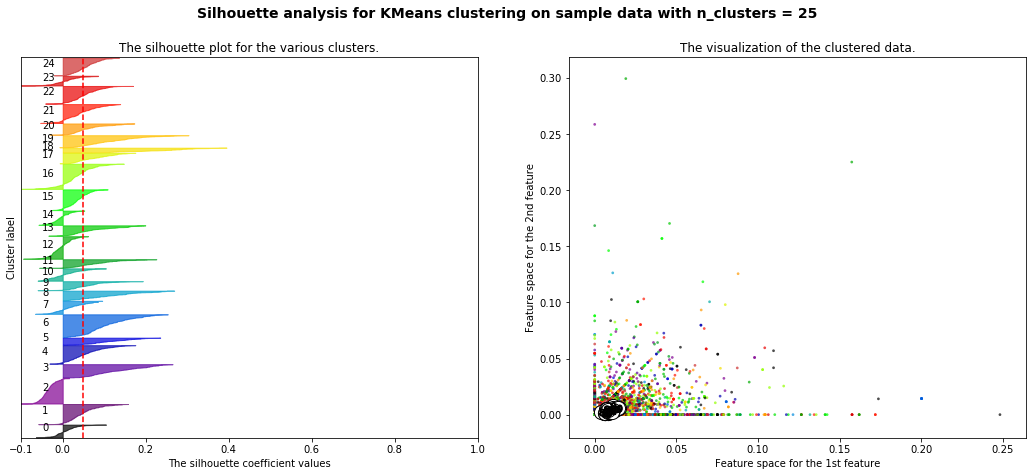

For n_clusters = 35 The average silhouette_score is : 0.0490701958261 Calinski harab is: 72.8585258687


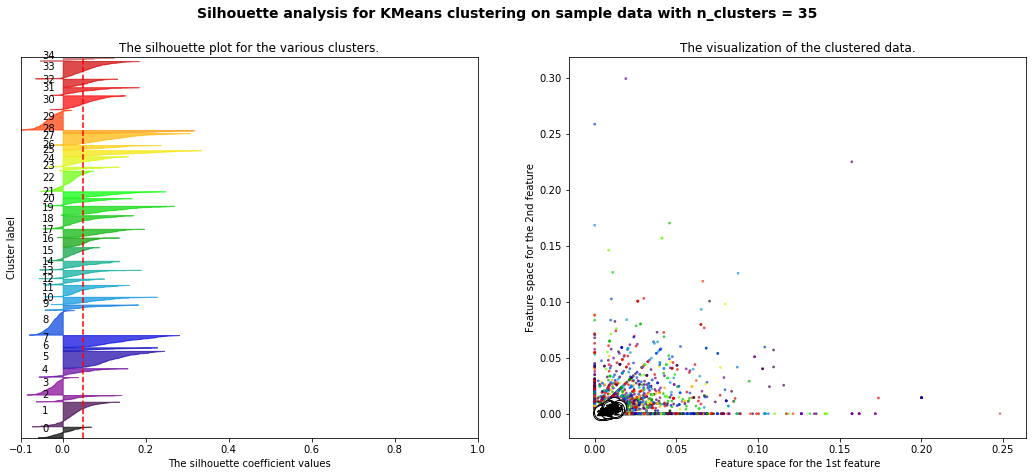

For n_clusters = 45 The average silhouette_score is : 0.0498990463861 Calinski harab is: 62.1978767842


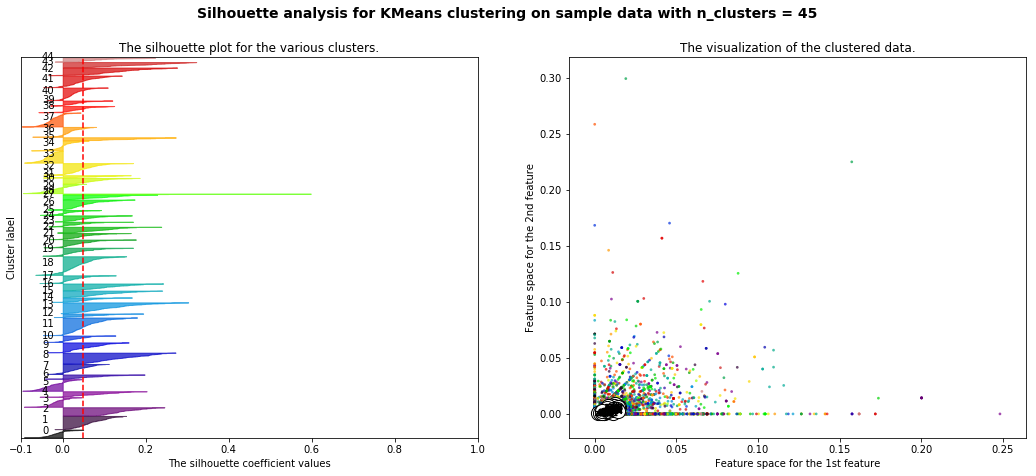

In [30]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np



range_n_clusters = [25,35,45]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(values) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(values)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(values, cluster_labels)
    calinski_harabaz = metrics.calinski_harabaz_score(values,cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg,
         "Calinski harab is:",calinski_harabaz)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(values, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(values[:, 0], values[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()